In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', None)

import re

import seaborn as sea
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

from nanoporePipelineCommon import *

print("imports done")

imports done


In [43]:
gtf_parquet_path = "/data16/marcus/genomes/elegansRelease100/Caenorhabditis_elegans.WBcel235.100.gtf.parquet"

gtf_df = pd.read_parquet(gtf_parquet_path)

In [46]:
gtf_df.query("gene_name == 'ubl-1'").query("feature == 'transcript'")

,chr,source,feature,start,end,score,strand,frame,gene_name,gene_id,gene_version,gene_source,gene_biotype,transcript_id,transcript_source,transcript_biotype,exon_number,exon_id
654650,III,WormBase,transcript,3068306,3069209,.,+,.,ubl-1,WBGene00006725,1,WormBase,protein_coding,H06I04.4a.3,WormBase,protein_coding,NaN,None
654661,III,WormBase,transcript,3068310,3069200,.,+,.,ubl-1,WBGene00006725,1,WormBase,protein_coding,H06I04.4b.1,WormBase,protein_coding,NaN,None
654672,III,WormBase,transcript,3068317,3069210,.,+,.,ubl-1,WBGene00006725,1,WormBase,protein_coding,H06I04.4a.1,WormBase,protein_coding,NaN,None
654683,III,WormBase,transcript,3068317,3069209,.,+,.,ubl-1,WBGene00006725,1,WormBase,protein_coding,H06I04.4a.2,WormBase,protein_coding,NaN,None


In [6]:
import pyranges

bed = pyranges.read_bed("/data16/marcus/genomes/elegansRelease100/Caenorhabditis_elegans.WBcel235.100.bed").df

In [7]:
bed_df = bed.copy()
bed_df[['transcipt_name', 'gene_type', 'gene_name']] = bed_df.Name.str.split("|", expand=True)
bed_df

,Chromosome,Start,End,Name,Score,Strand,ThickStart,ThickEnd,ItemRGB,BlockCount,BlockSizes,BlockStarts,transcipt_name,gene_type,gene_name
0,I,11494,16837,Y74C9A.2a.1|protein_coding|nlp-40,1000,+,11640,16582,"0,128,255",4,"67,72,210,365,","0,123,3456,4978,",Y74C9A.2a.1,protein_coding,nlp-40
1,I,11494,16793,Y74C9A.2a.3|protein_coding|nlp-40,1000,+,11640,16582,"0,128,255",5,"67,72,210,113,92,","0,123,3456,4978,5207,",Y74C9A.2a.3,protein_coding,nlp-40
2,I,11498,16837,Y74C9A.2a.4|protein_coding|nlp-40,1000,+,11640,16582,"0,128,255",4,"59,72,210,365,","0,119,3452,4974,",Y74C9A.2a.4,protein_coding,nlp-40
3,I,11504,16837,Y74C9A.2a.5|protein_coding|nlp-40,1000,+,11640,16582,"0,128,255",4,"57,67,210,365,","0,118,3446,4968,",Y74C9A.2a.5,protein_coding,nlp-40
4,I,11617,16837,Y74C9A.2a.2|protein_coding|nlp-40,1000,+,11640,16582,"0,128,255",3,"72,210,365,","0,3333,4855,",Y74C9A.2a.2,protein_coding,nlp-40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61446,X,17670594,17670737,T23E7.9|ncRNA|T23E7.9,1000,-,17670594,17670737,"196,196,196",1,"143,","0,",T23E7.9,ncRNA,T23E7.9
61447,X,17673475,17673496,T23E7.7|piRNA|21ur-12330,1000,-,17673475,17673496,"196,196,196",1,"21,","0,",T23E7.7,piRNA,21ur-12330
61448,X,17680872,17682294,T23E7.6.1|protein_coding|T23E7.6,1000,-,17680913,17682294,"0,128,255",2,"153,95,","0,1327,",T23E7.6.1,protein_coding,T23E7.6
61449,X,17697238,17697346,F20B4.8|antisense_RNA|anr-17,1000,-,17697238,17697346,"196,196,196",1,"108,","0,",F20B4.8,antisense_RNA,anr-17


In [8]:
def str_list_to_list_of_ints(row, column):
    if col == 'ItemRGB':
        last_parse_keeper = 3
    else:
        last_parse_keeper = -1
    return list(map(int, row[column].split(',')[:last_parse_keeper]))

for col in ['BlockSizes', 'BlockStarts', 'ItemRGB']:
    try:
        tqdm.pandas(desc=f"Parsing the column: {col}")
        bed_df[col] = bed_df.progress_apply(lambda row: str_list_to_list_of_ints(row, col), axis=1)
    except AttributeError:
        print(f"The {col} already appears to have been parsed!! Ignoring this column!")

Parsing the column: ItemRGB: 100%|██████████| 61451/61451 [00:00<00:00, 113753.21it/s]


In [18]:
test_df = bed_df.query("gene_name == 'ubl-1'").reset_index(drop=True)
test_df

,Chromosome,Start,End,Name,Score,Strand,ThickStart,ThickEnd,ItemRGB,BlockCount,BlockSizes,BlockStarts,transcipt_name,gene_type,gene_name
0,III,3068305,3069209,H06I04.4a.3|protein_coding|ubl-1,1000,+,3068334,3069158,"[0, 128, 255]",3,"[162, 170, 237]","[0, 268, 667]",H06I04.4a.3,protein_coding,ubl-1
1,III,3068309,3069200,H06I04.4b.1|protein_coding|ubl-1,1000,+,3068334,3068589,"[0, 128, 255]",3,"[158, 162, 228]","[0, 272, 663]",H06I04.4b.1,protein_coding,ubl-1
2,III,3068316,3069210,H06I04.4a.1|protein_coding|ubl-1,1000,+,3068334,3069158,"[0, 128, 255]",3,"[151, 170, 238]","[0, 257, 656]",H06I04.4a.1,protein_coding,ubl-1
3,III,3068316,3069209,H06I04.4a.2|protein_coding|ubl-1,1000,+,3068334,3069158,"[0, 128, 255]",3,"[151, 170, 237]","[0, 257, 656]",H06I04.4a.2,protein_coding,ubl-1


Parsing the column: ItemRGB: 100%|██████████| 4/4 [00:00<00:00, 1023.44it/s]


H06I04.4a.3

H06I04.4b.1

H06I04.4a.1

H06I04.4a.2



/tmp/ipykernel_168299/2039708096.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


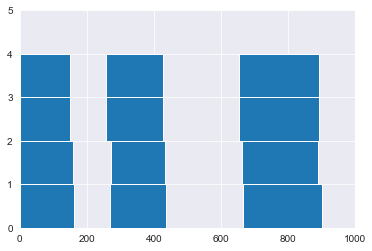

In [24]:
fig, ax = plt.subplots()
def row_plot_rectangles(row, axes):
    index = row.name
    transcript_start = row['Start']
    transcript_edit = row['End']
    cds_start = row['ThickStart']
    cds_end = row['ThickEnd']
    exon_starts = row['BlockStarts']
    exon_lengths = row['BlockSizes']
    print(f"\n{row['transcipt_name']}")
    rectangle_patches = []
    for (exon_start, exon_length) in zip(exon_starts, exon_lengths):
        rectangle_patches.append(Rectangle((exon_start, index), exon_length, height=1))
    axes.add_collection(PatchCollection(rectangle_patches))

test_df.progress_apply(lambda row: row_plot_rectangles(row, ax), axis=1)

ax.set_ylim(0,5)
ax.set_xlim(0,1000)
fig.show()